# Lattice scalar theory in 0D (cont.) - Autocorrelation

## The story so far...

* We are dealing with a zero-dimensional scalar field theory, described by the action $S[\phi] = \phi^{2}$.
* We are interested in obtaining expectation values of $O[\phi] = \phi^{n}$, $n > 0$, given by
\begin{equation}
    \text{E}\left[ \phi^{n} \right] = \int\limits_{-\infty}^{\infty} \mathrm{d}\phi \; \phi^{n} P(\phi), \qquad P(\phi):= \frac{\mathrm{e}^{-\phi^{2}}}{Z}, \qquad Z := \int\limits_{-\infty}^{\infty} \mathrm{d}\phi \; \mathrm{e}^{-\phi^{2}}.
\end{equation}
* The Metropolis algorithm was introduced as a method to obtain samples of the field $\phi$ (approximately) distributed according to $P(\phi)$, and with it, we also introduced the concepts of _thermalization_, _acceptance rate_ and _tuning_ of the hyperparameters.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


def compute_action(phi: float) -> float:
    return phi ** 2


def propose_phi(phi: float,
                width: float,
                rng: np.random.Generator) -> float:
    delta = 2. * rng.random() - 1.  # Random number between -1 and 1.
    return phi + width * delta


def metropolis_step(phi: float,
                    width: float,
                    rng: np.random.Generator) -> tuple[float, int]:
    # 1. Proposal
    proposed_phi = propose_phi(phi, width, rng)

    # 2. Acceptance probability.
    current_action = compute_action(phi)
    proposed_action = compute_action(proposed_phi)
    p_acceptance = min(1, np.exp(current_action - proposed_action))

    # 3. Accept/reject
    r = rng.random()

    if r <= p_acceptance:  # Accept.
        return proposed_phi, 1

    # Reject.
    return phi, 0


def sample_field(initial_phi: float,
                 num_samples: int,
                 width: float,
                 rng: np.random.Generator):
    acceptance = []
    chain = [initial_phi]

    for sample_idx in range(num_samples):
        phi, accepted = metropolis_step(chain[-1], width, rng)
        chain.append(phi)
        acceptance.append(accepted)

    return chain, acceptance

In [2]:
phi_samples, acceptances = sample_field(initial_phi=10.0,
                                        num_samples=55440 + 99,
                                        width=0.9,
                                        rng=np.random.default_rng(seed=42))
print(f"Acceptance rate: {np.mean(acceptances) * 100:.2f}%")

Acceptance rate: 75.32%


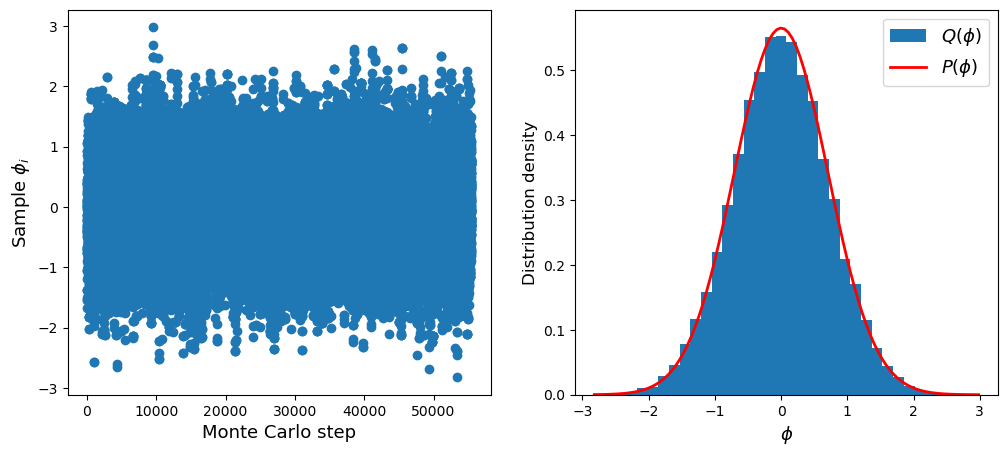

In [3]:
n_thermal = 100
phi_t_samples = phi_samples[n_thermal:]  # Thermalization.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(phi_t_samples, 'o')
axes[0].set_xlabel("Monte Carlo step", fontsize=13)
axes[0].set_ylabel(r"Sample $\phi_{i}$", fontsize=13)

phi_t_range = np.linspace(min(phi_t_samples), max(phi_t_samples), 100)
axes[1].hist(phi_t_samples, bins=36, density=True, label=r"$Q(\phi)$")
axes[1].plot(phi_t_range, np.exp(-(phi_t_range ** 2)) / np.sqrt(np.pi),
             color='red', linewidth=2, label=r"$P(\phi)$")
axes[1].set_xlabel(r"$\phi$", fontsize=13)
axes[1].set_ylabel("Distribution density", fontsize=12)
axes[1].legend(fontsize=13)
plt.show()

## Measurements

Once we have thermalized samples $\left\{ \phi \right\} = \left\{ \phi_{1}, \dots, \phi_{N} \right\}$ that (approximately) follow $P(\phi)$, how do we compute the expectation value of $O[\phi]$?

As mentioned earlier, the expectation value is given by the integral
\begin{equation}
    \text{E}[O] = \int\limits_{-\infty}^{\infty} \mathrm{d}\phi \; O[\phi] P(\phi).
\end{equation}
Here, $P(\phi)$ is a probability density, and the product $P(\phi) \; \mathrm{d}\phi$ is the probability of having a value $\phi$ within an infinitesimal interval $\mathrm{d}\phi$. \
Hence, the integral simply expresses a sum over the values of $O[\phi]$, each multiplied or weighed by its probability $P(\phi) \; \mathrm{d}\phi$.

For a Markov chain of samples $\{ \phi \}$, to say that they are distributed according to $P(\phi)$ means that any particular value $\phi$ will appear in the chain with a probability $\sim P(\phi) \mathrm{d}\phi$, and, therefore, we can _estimate_ the expectation value with the sample mean of the values of the operator:
\begin{equation}
    \text{E}[O] =
    \int\limits_{-\infty}^{\infty} \mathrm{d}\phi \; O[\phi] \, P(\phi)
    \approx
    \langle O \rangle := \frac{1}{N} \sum_{k = 1}^{N} O[\phi_{k}], \quad \phi_{k} \sim P(\phi).
\end{equation}

* The fact that we can approximate the integral by evaluating only the operators at the values of the field is a particular case of [_importance sampling_](https://en.wikipedia.org/wiki/Importance_sampling).

In [4]:
powers = [1, 2, 3, 4] #these define the observables O[phi] = phi^power
exacts = [0, 0.5, 0, 0.75] #we know that/can calculate it analytically
values = [np.mean(np.array(phi_t_samples) ** i) for i in powers]
header = "O[phi]\t|\tExact\t|\tEstimate"
print(header)
print("-" * (len(header) + 7))
[print(f"phi^{p}\t|\t{exacts[idx]:4g}\t|\t{values[idx]:7.4f}") for idx, p in enumerate(powers)];
#not so good, as we have no errors so far

O[phi]	|	Exact	|	Estimate
--------------------------------
phi^1	|	   0	|	-0.0037
phi^2	|	 0.5	|	 0.5122
phi^3	|	   0	|	-0.0085
phi^4	|	0.75	|	 0.7741


## Estimating errors

Presenting an estimated value without its associated error is meaningless!

By using the sample mean as our estimate, the associated statistical error is given by the root-mean-square deviation of the sample mean from the true expectation value:
\begin{equation}
    \text{E}\left[ \left( \langle O \rangle - \text{E}[O] \right)^{2} \right] = \frac{\text{Var}[O]}{N} + \frac{2}{N^{2}} \sum_{t = 1}^{N - 1} (N - t) \, C_{1, t + 1}[O],
\end{equation}
where
\begin{equation}
    \text{Var}[O] = \text{E}[O^{2}] - \text{E}[O]^{2},
    \qquad
    C_{i j}[O] = \text{E}\left[ O_{i} O_{j} \right] - \text{E}^{2}[O] = C_{j i}[O].
\end{equation}
If we assume that the samples are independent, then
\begin{equation}
    \forall i \neq j: \quad \text{E}\left[ O_{i} O_{j} \right] = \text{E}\left[ O_{i} \right] \text{E}\left[ O_{j} \right] = \text{E}[O]^{2}
    \implies
    C_{i j}[O] = 0,
\end{equation}
and the statistical error becomes
\begin{equation}
    \text{E}\left[ \left( \langle O \rangle - \text{E}[O] \right)^{2} \right] = \frac{\text{Var}[O]}{N}.
\end{equation}
However, since we cannot obtain expectation values, but estimate them, we instead _also estimate the statistical error_ through the expression
\begin{equation}
    \sigma := \frac{\sigma_{O}}{\sqrt{N - 1}} = \sqrt{\frac{\langle O^{2} \rangle - \langle O \rangle^{2}}{N - 1}}.
\end{equation}
The validity of this estimator comes from the fact that its expectation value matches the statistical error:
\begin{equation}
    \begin{aligned}
        \text{E}\left[ \langle O^{2} \rangle - \langle O \rangle^{2} \right]
        & =
        (N - 1) \frac{\text{Var}[O]}{N} - \frac{2}{N^{2}} \sum_{t = 1}^{N - 1} (N - t) \, C_{1, t + 1}[O] \\
        &
        \overset{\text{ind.}}{=} (N - 1) \frac{\text{Var}[O]}{N} \\
        &
        \implies \text{E}\left[ \frac{\langle O^{2} \rangle - \langle O \rangle^{2}}{N - 1} \right] = \frac{\text{Var}[O]}{N}.
    \end{aligned}
\end{equation}

In [5]:
errors = [np.std(np.array(phi_t_samples) ** i) / np.sqrt(len(phi_t_samples) - 1) for i in powers]
sigmas = [np.abs(values[i] - exacts[i]) / errors[i] for i in range(len(powers))]
header = "O[phi]\t|\tExact\t|\t\tEstimate\t\t|\tSigmas from exact value"
print(header)
print("-" * (len(header) + 18))
[print(f"phi^{p}\t|\t{exacts[idx]:4g}\t|\t{values[idx]:7.4f} +/- {errors[idx]:.4f}\t|\t\t\t{sigmas[idx]:.1f}")
 for idx, p in enumerate(powers)];
#this is called the naive error estimation, as we assume the samples to be independent (no autocorrelation)

O[phi]	|	Exact	|		Estimate		|	Sigmas from exact value
-----------------------------------------------------------------------
phi^1	|	   0	|	-0.0037 +/- 0.0030	|			1.2
phi^2	|	 0.5	|	 0.5122 +/- 0.0030	|			4.0
phi^3	|	   0	|	-0.0085 +/- 0.0058	|			1.5
phi^4	|	0.75	|	 0.7741 +/- 0.0101	|			2.4


## Autocorrelation

In the above examples we can see that, in some cases, the estimated error seems to underestimate the actual error. \
Since we typically don't know the exact values, it is important to be careful with how we estimate the error and the assumptions that we make in doing so.

When generating a chain of samples via the Metropolis algorithm, any sample $\phi_{i + 1}$ is either equal to $\phi_{i}$ or a “local” modification of it. \
For example, in our case $\phi_{i + 1} \in [\phi_{i} - w, \phi_{i} + w]$. \
This means that $\phi_{i}$ and $\phi_{i + 1}$ are not independent: $\phi_{i + 1}$ was not randomly chosen from among the entire sample space, but rather from a part of it determined by $\phi_{i}$. \
As we consider elements at “farther” positions in the chain, such as $\phi_{i}$ and $\phi_{i + 10}$, we expect the latter to be less influenced by the former, due to the many random steps between them. \
Therefore, we need to abandon the assumption that all of our samples are independent of one another, and instead _try to quantify how many samples can actually be considered independent_.

This is the idea of **autocorrelation**.

Without the assumption of independent samples, the statistical error is then
\begin{equation}
    \begin{aligned}
        \text{E}\left[ \left( \langle O \rangle - \text{E}[O] \right)^{2} \right]
        & =
        \frac{\text{Var}[O]}{N} + \frac{2}{N^{2}} \sum_{t = 1}^{N - 1} (N - t) \, C_{1, t + 1}[O]
        \\
        & =
        2 \left( \frac{1}{2} + \sum_{t = 1}^{N - 1} \left( 1 - \frac{t}{N}\right) \, \frac{C_{1, t + 1}[O]}{\text{Var}[O]} \right) \frac{\text{Var}[O]}{N}
        \\
        & \approx
        2 \tau_{\text{int}} \frac{\text{Var}[O]}{N},
    \end{aligned}
\end{equation}
where
\begin{equation}
    \tau_{\text{int}} = \frac{1}{2} + \sum_{t = 1}^{N - 1} \frac{C_{1, t + 1}[O]}{\text{Var}[O]}
\end{equation}
denotes the _integrated autocorrelation time_, a rough measure of how many Monte Carlo steps there must be between two samples to consider them independent.

It is important to notice that, since $\tau_{\text{int}} > 1/2$ for correlated samples, taking autocorrelation into account leads to an increase in the statistical error when compared with independent samples. \
Alternatively, one can also speak of an “effective sample size”, $N_{\text{eff}} = N / (2 \tau_{\text{int}})$, showing that _long autocorrelation times lead to small effective sample sizes_.

Remark: The $\tau_{int}$ depends on the observable! We need to recalculate it for every observable!

### The binning method

In practice, estimating the autocorrelation time is not a trivial task. \
Instead, a relatively easy method to take autocorrelation into account for estimating errors is the **binning method**. \
This method provides _the same value for the mean_, but changes the estimate of the error, and it consists of the following steps:
1. Start with a chain of (thermalized) samples of the observable, $\{ O_{1}, O_{2}, \dots, O_{N} \}$.
2. For a series of bin sizes $b_{1}, b_{2}, \dots, b_{s}$:
    1. Rearrange the chain into bins of the given bin size _using consecutive samples_.
    2. Average the values in each bin.
    3. Consider the new chain as having independent samples and compute the “naive” error.
3. The previous step results in a series of errors $\sigma_{1}, \sigma_{2}, \dots, \sigma_{s}$ (one for each bin size). \
Plot the errors as a function of the bin size. \
If you have enough data, you should see the errors starting to plateau with increasing bin size.
4. The error estimate corresponds to this limiting value.

To exemplify what happens in the second step of this process, consider a chain with 12 samples of the observable $\{ O_{1}, \dots, O_{12} \}$. \
 For a bin size 3, rearranging the chain and averaging looks as follows
 \begin{equation}
    \{ O_{1}, \dots, O_{12} \}
    \mapsto
    \begin{pmatrix}
        O_{1} & O_{2} & O_{3} \\
        O_{4} & O_{5} & O_{6} \\
        O_{7} & O_{8} & O_{9} \\
        O_{10} & O_{11} & O_{12}
    \end{pmatrix}
    \mapsto
    \{ O'_{1}, O'_{2}, O'_{3}, O'_{4} \}
 \end{equation}
 where $O'_{i} = (O_{i} + O_{i + 1} + O_{i + 2}) / 3$. \
 Then, the error is computed “naively” for $\{O'\}$, i.e., with the expression
 \begin{equation}
    \sigma = \sqrt{\frac{\langle O'{}^{2} \rangle - \langle O' \rangle^{2}}{N_{O'} - 1}}, \qquad N_{O'} = 4.
 \end{equation}

### Applying the binning method

In [ ]:
# We use divisors of the number of samples as potential bin sizes.
sample_size = len(phi_t_samples)
max_search = int(np.sqrt(sample_size)) + 2
bin_sizes = []
for i in range(1, max_search):
    if sample_size % i == 0:
        bin_sizes.append(i)
        bin_sizes.append(sample_size // i)
bin_sizes.sort()
print(bin_sizes)

55440
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 24, 28, 30, 33, 35, 36, 40, 42, 44, 45, 48, 55, 56, 60, 63, 66, 70, 72, 77, 80, 84, 88, 90, 99, 105, 110, 112, 120, 126, 132, 140, 144, 154, 165, 168, 176, 180, 198, 210, 220, 231, 240, 252, 264, 280, 308, 315, 330, 336, 360, 385, 396, 420, 440, 462, 495, 504, 528, 560, 616, 630, 660, 693, 720, 770, 792, 840, 880, 924, 990, 1008, 1155, 1232, 1260, 1320, 1386, 1540, 1584, 1680, 1848, 1980, 2310, 2520, 2640, 2772, 3080, 3465, 3696, 3960, 4620, 5040, 5544, 6160, 6930, 7920, 9240, 11088, 13860, 18480, 27720, 55440]


In [7]:
# We choose an observable to measure and apply the binning method.
phi2_measurements = np.array(phi_t_samples) ** 2
binned_errors = []
for bin_idx, my_bin_size in enumerate(bin_sizes):
    M_k = len(phi2_measurements) // my_bin_size
    if M_k < 250:  # If we get a reduced chain with less than 200 samples, we stop binning.
        bin_sizes = bin_sizes[:bin_idx]
        break
    binned_test_obs = phi2_measurements.reshape(M_k, my_bin_size)
    binned_test_obs = np.mean(binned_test_obs, axis=1)
    binned_errors.append(np.std(binned_test_obs) / np.sqrt(M_k))

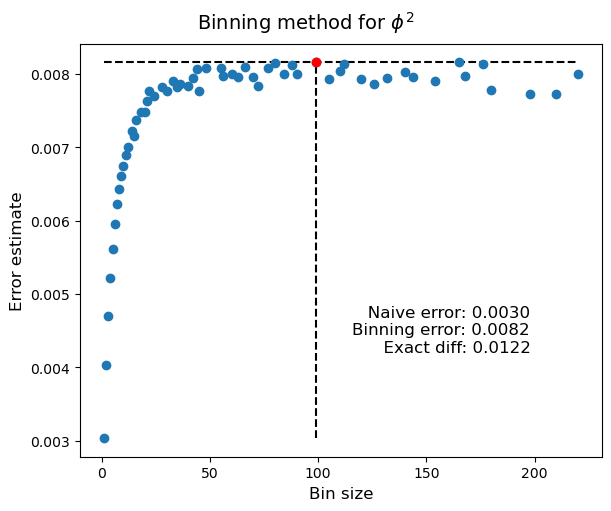

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), constrained_layout=True)
fig.suptitle(r"Binning method for $\phi^{2}$", fontsize=14)
bin_idx = 42
ax.scatter(bin_sizes, binned_errors)
ax.vlines(x=bin_sizes[bin_idx],
          ymin=np.min(binned_errors),
          ymax=np.max(binned_errors),
          color='k',
          linestyle='--', zorder=0)
ax.hlines(y=binned_errors[bin_idx],
          xmin=np.min(bin_sizes),
          xmax=np.max(bin_sizes),
          color='k',
          linestyle='--', zorder=0)
ax.scatter(bin_sizes[bin_idx], binned_errors[bin_idx], color='r')
ax.annotate(f"   Naive error: {errors[1]:.4f}\n"
            f"Binning error: {binned_errors[bin_idx]:.4f}\n"
            f"      Exact diff: {np.abs(np.mean(phi2_measurements) - exacts[1]):.4f}",
            xy=(0.5 * ax.get_xlim()[1], 0.5 * ax.get_ylim()[1]), fontsize=12)
ax.set_xlabel("Bin size", fontsize=12)
ax.set_ylabel("Error estimate", fontsize=12)
plt.show()

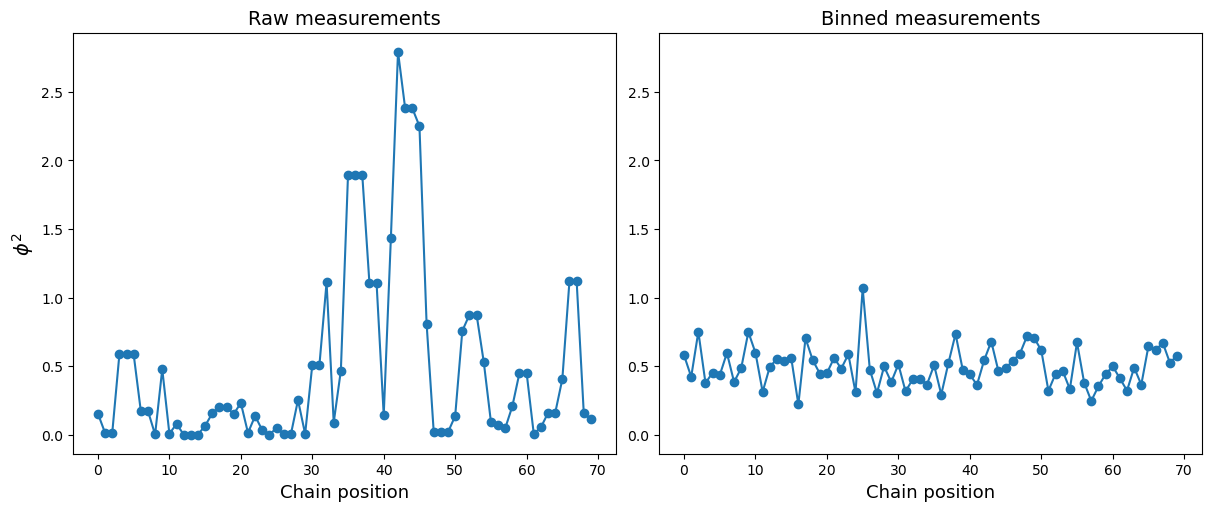

In [9]:
binned_phi2_measurements = np.mean(phi2_measurements.reshape(
    len(phi2_measurements) // bin_sizes[bin_idx], bin_sizes[bin_idx]), axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True, sharey=True)
axes[0].plot(phi2_measurements[:70], '-o')
axes[0].set_title("Raw measurements", fontsize=14)
axes[0].set_xlabel("Chain position", fontsize=13)
axes[0].set_ylabel(r"$\phi^{2}$", fontsize=14)
axes[1].plot(binned_phi2_measurements[:70], '-o')
axes[1].yaxis.set_tick_params(labelbottom=True)
axes[1].set_title("Binned measurements", fontsize=14)
axes[1].set_xlabel("Chain position", fontsize=13)
plt.show()

## Fun fact

In order to have a great number of bin sizes to try for the binning method, the initial sample size was chosen such that, after thermalization, the remaining amount of samples was a [highly composite number](https://en.wikipedia.org/wiki/Highly_composite_number).